![PySpark](images/pyspark.jpeg)

# Spark intro
![cluster-overview](images/cluster-overview.png)

# Spark Session - Local Cluster
 - One new param! spark.sql.execution.arrow.enabled  

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark Demo") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

In [8]:
# from pyspark.sql.types import *
from pyspark.sql.functions import col, rand

# Make some dummy data
df = spark.range(0, 1000 * 1000).withColumn('id', (col('id') / 10000).cast('integer')).withColumn('v', rand())
df.show(5)

+---+-------------------+
| id|                  v|
+---+-------------------+
|  0| 0.3967766438117645|
|  0|0.45500210706749344|
|  0| 0.2599081632841832|
|  0| 0.4814453545972326|
|  0|  0.252680270161203|
+---+-------------------+
only showing top 5 rows



# Simple Python UDF (x+1)

![python_udf](images/python_udf.png)

In [79]:
from pyspark.sql.functions import udf, count

@udf('double')
def plus_one(v):
    return v + 1

df.withColumn('v_plus1', plus_one(df.v)).show(5)

+---+-------------------+------------------+
| id|                  v|           v_plus1|
+---+-------------------+------------------+
|  0| 0.3967766438117645|1.3967766438117644|
|  0|0.45500210706749344|1.4550021070674934|
|  0| 0.2599081632841832|1.2599081632841833|
|  0| 0.4814453545972326|1.4814453545972326|
|  0|  0.252680270161203| 1.252680270161203|
+---+-------------------+------------------+
only showing top 5 rows



In [10]:
# Timing.  Including aggregation to avoid optimising out the UDF calculation.
plus_one_results = %timeit -o -n5 -r1 df.withColumn('v_plus1', plus_one(df.v)).agg(count(col('v_plus1'))).show()

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

612 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


# Pandas UDF Equivalent (x+1)
 - Default is mode is PandasUDFType.SCALAR

![pandas_udf](images/pandas_scalar_udf.png)

In [22]:
from pyspark.sql.functions import pandas_udf

@pandas_udf("double")
def pandas_plus_one(v):
    #print(v)
    return v + 1

df.withColumn('v_plus1', pandas_plus_one(df.v)).show(5)

+---+-------------------+------------------+
| id|                  v|           v_plus1|
+---+-------------------+------------------+
|  0| 0.3967766438117645|1.3967766438117644|
|  0|0.45500210706749344|1.4550021070674934|
|  0| 0.2599081632841832|1.2599081632841833|
|  0| 0.4814453545972326|1.4814453545972326|
|  0|  0.252680270161203| 1.252680270161203|
+---+-------------------+------------------+
only showing top 5 rows



In [12]:
pandas_plus_one_results = %timeit -o -n5 -r1 df.withColumn('v_plus1', pandas_plus_one(df.v)).agg(count(col('v_plus1'))).show()

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

380 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


# More Meaningful Example
 - Vectorised operations == SPEED!

# UDF example:

In [13]:
import pandas as pd
from scipy import stats

@udf('double')
def cdf(v):
    # stats.norm.cdf works on ints, lists, Pandas Series and NumPy arrays
    return float(stats.norm.cdf(v))

df.withColumn('cumulative_probability', cdf(df.v)).show(5)

+---+-------------------+----------------------+
| id|                  v|cumulative_probability|
+---+-------------------+----------------------+
|  0| 0.3967766438117645|    0.6542339122360233|
|  0|0.45500210706749344|    0.6754461385195595|
|  0| 0.2599081632841832|    0.6025326928849651|
|  0| 0.4814453545972326|    0.6848999956666635|
|  0|  0.252680270161203|    0.5997423523153556|
+---+-------------------+----------------------+
only showing top 5 rows



In [14]:
# Timing
cdf_results = %timeit -o -n3 -r1 df.withColumn('cumulative_probability', cdf(df.v)).agg(count(col('cumulative_probability'))).show()

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

26.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


# Pandas UDF Example
 - Uses NumPy for CDF operation on an array instead of one number per function call

In [15]:
import pandas as pd
from scipy import stats

# returnType=PandasUDFType.SCALAR is implied
@pandas_udf('double')
def pandas_cdf(v):
    return pd.Series(stats.norm.cdf(v))

df.withColumn('cumulative_probability', pandas_cdf(df.v)).show(5)

+---+-------------------+----------------------+
| id|                  v|cumulative_probability|
+---+-------------------+----------------------+
|  0| 0.3967766438117645|    0.6542339122360233|
|  0|0.45500210706749344|    0.6754461385195595|
|  0| 0.2599081632841832|    0.6025326928849651|
|  0| 0.4814453545972326|    0.6848999956666635|
|  0|  0.252680270161203|    0.5997423523153556|
+---+-------------------+----------------------+
only showing top 5 rows



In [16]:
# Timing
pandas_cdf_results = %timeit -o -n5 -r1 df.withColumn('cumulative_probability', pandas_cdf(df.v)).agg(count(col('cumulative_probability'))).show()

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

373 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


# Python UDF (list of rows)
 - Packs multiple rows into a single row
 - Complicated!

In [24]:
from pyspark.sql.functions import col, count, rand, collect_list, explode, struct, count, lit
from pyspark.sql import Row
from pyspark.sql.types import ArrayType

@udf(ArrayType(df.schema))
def substract_mean(rows):
    vs = pd.Series([r.v for r in rows])
    vs = vs - vs.mean()
    return [Row(id=rows[i]['id'], v=float(vs[i])) for i in range(len(rows))]

df.groupby('id') \
    .agg(collect_list(struct(df['id'], df['v'])).alias('rows')) \
    .withColumn('new_rows', substract_mean(col('rows'))) \
    .withColumn('new_row', explode(col('new_rows'))) \
    .withColumn('id', col('new_row.id')) \
    .withColumn('v', col('new_row.v')) \
    .show(5)

+---+--------------------+--------------------+--------------------+--------------------+
| id|                rows|            new_rows|             new_row|                   v|
+---+--------------------+--------------------+--------------------+--------------------+
| 31|[[31, 0.746147407...|[[31, 0.243052882...|[31, 0.2430528828...|  0.2430528828768127|
| 31|[[31, 0.746147407...|[[31, 0.243052882...|[31, 0.3647418368...| 0.36474183684153205|
| 31|[[31, 0.746147407...|[[31, 0.243052882...|[31, -0.032954635...|-0.03295463514344...|
| 31|[[31, 0.746147407...|[[31, 0.243052882...|[31, 0.4482174561...|  0.4482174561707901|
| 31|[[31, 0.746147407...|[[31, 0.243052882...|[31, -0.398870948...|-0.39887094817538515|
+---+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [25]:
# Timing
py_subtract_mean_results = %timeit -o -n3 -r1 df.groupby('id') \
    .agg(collect_list(struct(df['id'], df['v'])).alias('rows')) \
    .withColumn('new_rows', substract_mean(col('rows'))) \
    .withColumn('new_row', explode(col('new_rows'))) \
    .withColumn('id', col('new_row.id')) \
    .withColumn('v', col('new_row.v')) \
    .agg(count(col('v'))) \
    .show()

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

11.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


# Pandas UDF Grouped Map
 - Extremely powerful and elegant
 - Pandas DataFrame input, Pandas DataFrame output

![grouped_map](images/pandas_grouped_map_udf.png)

In [66]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

df = spark.createDataFrame(
    [(0, 2.3, "apple"),
     (1, 1.0, "apple"),
     (2, 5.1, "orange"),
     (3, 6.5, "apple"),
     (4, 3.5, "orange"),
     (5, 6.4, "apple")],
    ("id", "value", "fruit"))

@pandas_udf("id long, value double, norm double, fruit string", PandasUDFType.GROUPED_MAP)
def normalize(pdf):
    v = pdf.value
    return pdf.assign(norm=(v - v.mean()) / v.std())

df.groupby("fruit").apply(normalize).show()

+---+-----+-------------------+------+
| id|value|               norm| fruit|
+---+-----+-------------------+------+
|  2|  5.1| 0.7071067811865475|orange|
|  4|  3.5|-0.7071067811865475|orange|
|  0|  2.3|-0.6201412226583429| apple|
|  1|  1.0|-1.0808175594902545| apple|
|  3|  6.5| 0.8681977117216795| apple|
|  5|  6.4| 0.8327610704269172| apple|
+---+-----+-------------------+------+



# Grouped Map
 - Faster and simpler

In [66]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(df.schema, PandasUDFType.GROUPED_MAP)
def pandas_subtract_mean(pdf):
    return pdf.assign(v=pdf.v - pdf.v.mean())

df.groupby('id').apply(pandas_subtract_mean).show(5)

+---+--------------------+
| id|                   v|
+---+--------------------+
| 31|  0.2430528828768127|
| 31| 0.36474183684153205|
| 31|-0.03295463514344...|
| 31|  0.4482174561707901|
| 31|-0.39887094817538515|
+---+--------------------+
only showing top 5 rows



In [28]:
#Timing
pd_subtract_mean_results = %timeit -o -n3 -r1 df.groupby('id').apply(pandas_subtract_mean).agg(count(col('v'))).show()

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

2.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


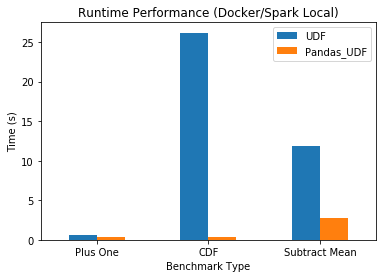

In [68]:
udf_data = (plus_one_results.average, cdf_results.average, py_subtract_mean_results.average)
pudf_data = (pandas_plus_one_results.average, pandas_cdf_results.average, pd_subtract_mean_results.average)
labels = ['Plus One', 'CDF', 'Subtract Mean']

perf_df = pd.DataFrame({'UDF': udf_data,
                        'Pandas_UDF': pudf_data}, index=labels)

ax = perf_df.plot.bar(title='Runtime Performance (Docker/Spark Local)', rot=0, figsize=(6, 4))
ax.set_xlabel('Benchmark Type')
ax.set_ylabel('Time (s)')
ax.figure.savefig('images/benchmarks.png', dpi=300)

![benchmarks_plot](images/benchmarks.png)

# GPU Compute
 - Spark DataFrame -> Pandas DataFrame -> NumPy Array
 - Normal CPython process on all Spark workers
 - C extensions/Cython/Numba/etc all available

# Rapids (rapids.ai):
![rapids](images/rapids_arrow.png)

# Rapids / PyGDF / cuDF
 - Requires Cuda + nVidia GPU
 - Sorry Apple fanboys, wrong hardware so no benchmarks

In [ ]:
from pygdf.dataframe import DataFrame
 
def gpu_plus_one_grouped(df.schema, PandasUDFType.GROUPED_MAP)
    def add_one(incol, outcol):
        # This functions gets JIT compiled into the 
        # CUDA kernel in the apply_rows() call
        outcol = incol + 1

    gpu_df = DataFrame(pdf)
    gpu_df = gpu_df.apply_rows(gpu_plus_one_grouped,
                               ['oldcol'],
                               {'newcol': np.int32})
    return gpu_df.to_pandas()
 
df.groupby('id').apply(gpu_plus_one_grouped)

# Koalas
 - Pandas like distributed DataFrame for Spark
 - Easy installation (Pip or Conda)
 - Incomplete but very active

In [62]:
!pip install koalas

In [73]:
import databricks.koalas as ks
import numpy as np
from scipy import stats

kdf = df.to_koalas()

kdf['newCol'] = kdf['v'] * kdf['id']
kdf.describe()

,id,v,newCol
count,1000000.000000,1.000000e+06,1000000.000000
mean,49.500000,5.003162e-01,24.769535
std,28.866084,2.885863e-01,21.956529
min,0.000000,6.506087e-07,0.000000
25%,24.000000,2.505411e-01,6.605426
50%,49.000000,5.009747e-01,18.456882
75%,74.000000,7.500864e-01,37.989822
max,99.000000,9.999993e-01,98.997088


In [67]:
# Back to a Spark DataFrame
sdf = kdf.to_spark()
sdf.show(5)

# Or other outputs:
#pdf = kdf.to_pandas()
#kdf.to_parquet('/file/path.parquet')

+---+-------------------+------+
| id|                  v|newCol|
+---+-------------------+------+
|  0| 0.3967766438117645|   0.0|
|  0|0.45500210706749344|   0.0|
|  0| 0.2599081632841832|   0.0|
|  0| 0.4814453545972326|   0.0|
|  0|  0.252680270161203|   0.0|
+---+-------------------+------+
only showing top 5 rows



# Acknowledgements and References
 - Spark and PySpark
 - Databricks benchmarks notebook
 - Rapids project
 - https://www.slideshare.net/KeithKraus/gpuaccelerating-udfs-in-pyspark-with-numba-and-pygdf

# Questions?